In [125]:
import sys
import os
import numpy as np
import copy
from random import shuffle
import math
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

root_ims_dir='/imagenetdb3/data/geo/siggraph_timelapse/imageAlignedLD/'
root_dir='/imagenetdb3/data/geo/siggraph_timelapse/'
annotations_dir=os.path.join(root_dir,'annotations')
attributes_file=os.path.join(annotations_dir,'attributes.txt')
annotations_file=os.path.join(annotations_dir,'annotations.tsv')


In [126]:
f=open(annotations_file,'rb')
annotations=f.readlines()
f=open(attributes_file,'rb')
attributes=f.readlines()

#Get index of summer and winter attributes
summer=[i for i in range(len(attributes)) if attributes[i].startswith('summer')]
winter=[i for i in range(len(attributes)) if attributes[i].startswith('winter')]
summer=summer[0]
winter=winter[0]

In [127]:
image_names=np.array([a.split('\t')[0].strip() for a in annotations])
summer_confidence_scores=[a.split('\t')[summer+1] for a in annotations]
summer_scores=[s.split(',')[0] for s in summer_confidence_scores]
winter_confidence_scores=[a.split('\t')[winter+1] for a in annotations]
winter_scores=[w.split(',')[0] for w in winter_confidence_scores]

#Get images with high scores of summer and winter
winter_array=np.array(winter_scores,float)
summer_array=np.array(summer_scores,float)
winter_inds=np.where(winter_array>=0.7)[0]
summer_inds=np.where(summer_array>=0.7)[0]

In [136]:
#Make tuple summer_im, winter_im, summer_confidence, winter_confidence
summer_winter_pairs=[] 
i=0
num_pairs=0

#Have a dict with keys as names of the root_dir of images for a particular
#Place and values as the summer/winter images for that place

im_roots=set([i.split('\t')[0].split('/')[0] for i in image_names])
im_dict={key: {} for key in im_roots}
for k in im_dict.keys():
    im_dict[k]['summer']=[]
    im_dict[k]['winter']=[]

for w in winter_inds:
        im_dict[image_names[w].split('/')[0]]['winter'].append((image_names[w],winter_array[w]))
for s in summer_inds:
        im_dict[image_names[s].split('/')[0]]['summer'].append((image_names[s],summer_array[s]))

In [137]:
TRAIN_PERCENTAGE=0.8
VAL_PERCENTAGE=0.1
TEST_PERCENTAGE=0.1

train_pairs=[]
val_pairs=[]
test_pairs=[]

num_pairs=0
train=False
val=False
test=False
cur_keys=0

#num_keys=len(im_dict.keys())
NUM_KEYS=20

for k in im_dict.keys():
    #Need to make sure train/test splits are from 
    #Different locations
    cur_keys += 1
    if num_pairs<TRAIN_PERCENTAGE*NUM_KEYS:
        train=True
    elif (num_pairs-TRAIN_PERCENTAGE*NUM_KEYS)/NUM_KEYS < VAL_PERCENTAGE:
        val=True
        train=False
        test=False
    elif num_pairs<NUM_KEYS:
        test=True
        train=False
        val=False
    else:
        train=False
        val=False
        test=False
    for s in im_dict[k]['summer']:
        for w in im_dict[k]['winter']:
          if s[0].split('/')[1] != w[0].split('/')[1]:
            if train is True:
              train_pairs.append((root_ims_dir[1:]+s[0],s[1],
                        root_ims_dir[1:]+w[0],w[1]))
              num_pairs += 1
                
              break
            elif val is True:
              val_pairs.append((root_ims_dir[1:]+s[0],s[1],
                        root_ims_dir[1:]+w[0],w[1])) 
              num_pairs += 1
              break
            elif test is True:
              test_pairs.append((root_ims_dir[1:]+s[0],s[1],
                        root_ims_dir[1:]+w[0],w[1]))
              num_pairs += 1
              break
        break  #All breaks make sure there is only one target image for each source image

print NUM_KEYS,num_pairs,len(train_pairs),len(val_pairs),len(test_pairs)

20 20 16 2 2


imagenetdb3/data/geo/siggraph_timelapse/imageAlignedLD/00008205/20120609_205720.jpg


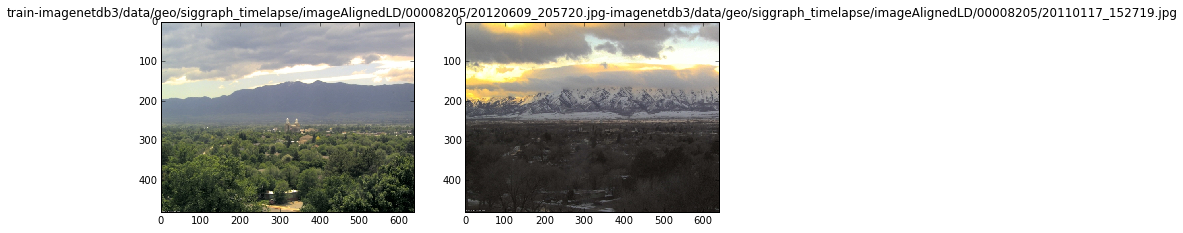

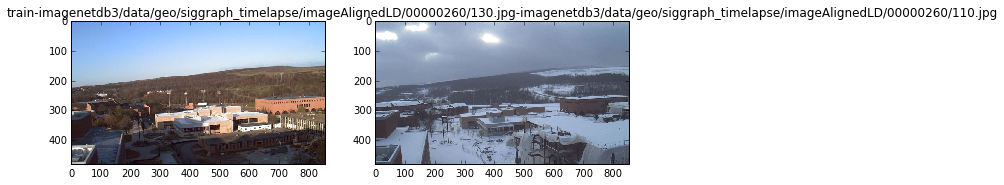

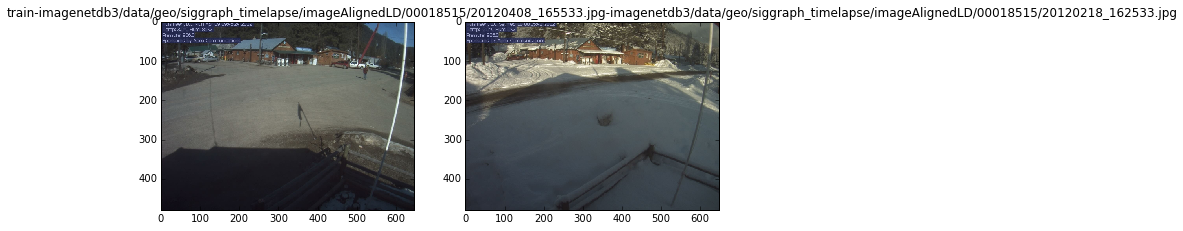

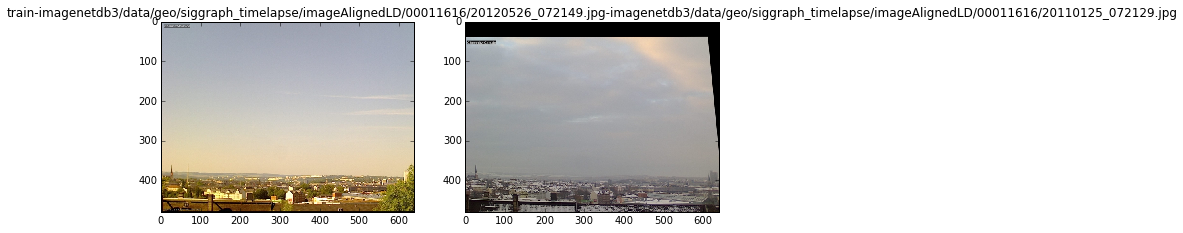

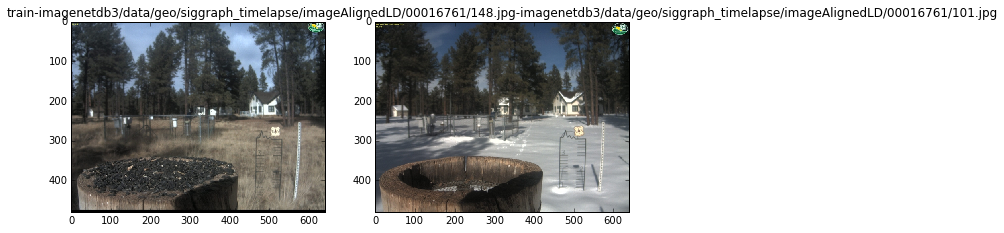

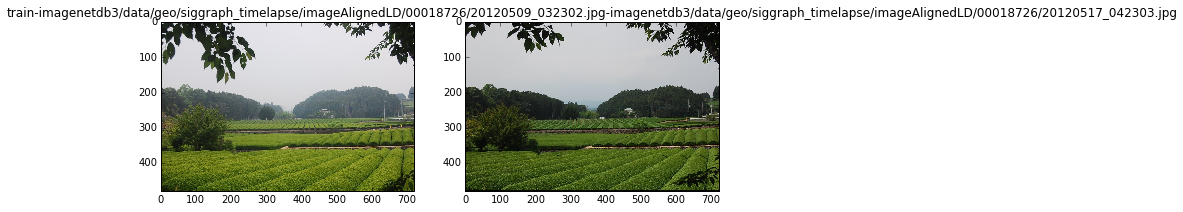

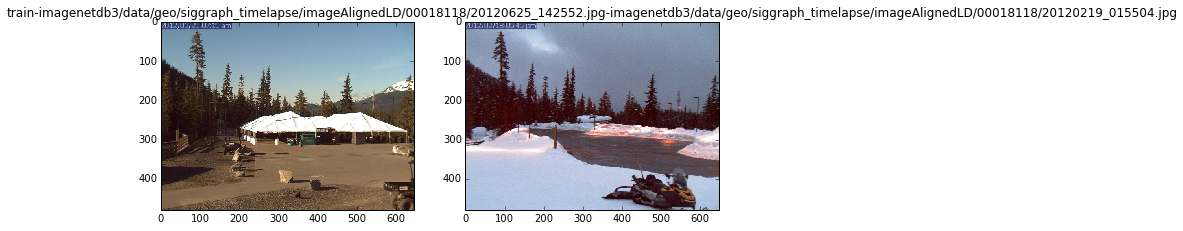

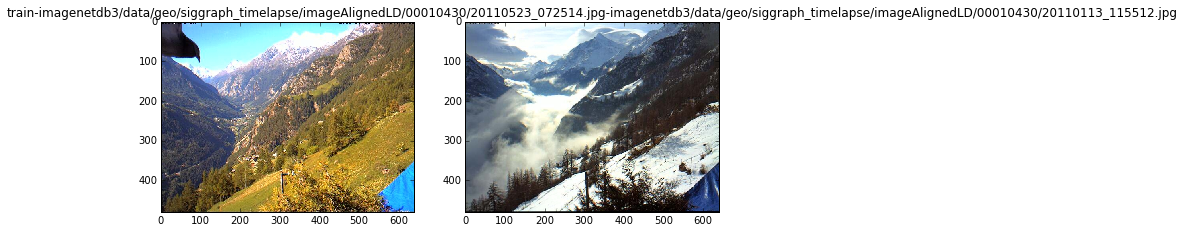

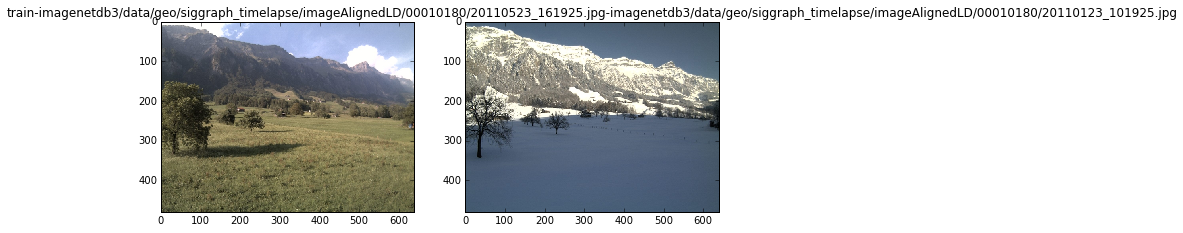

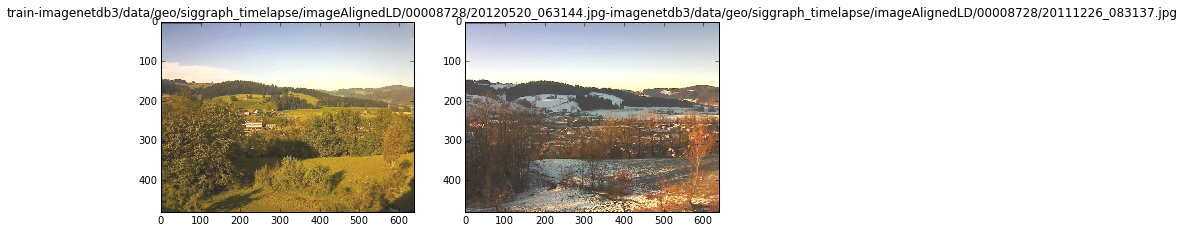

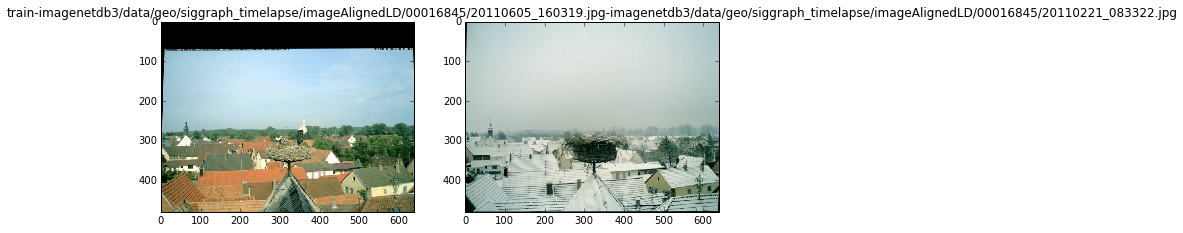

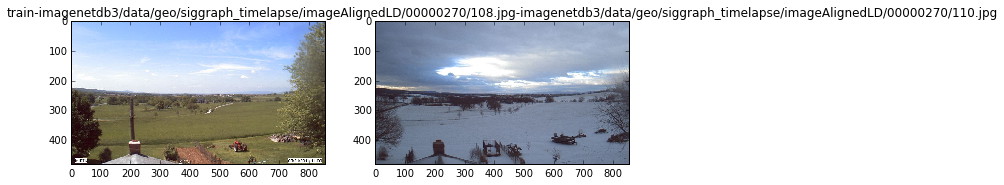

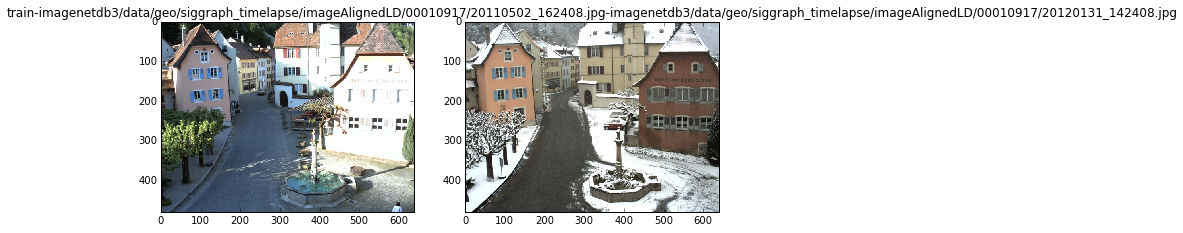

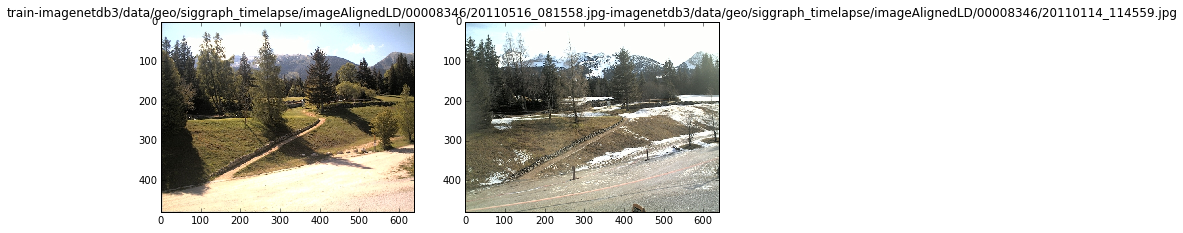

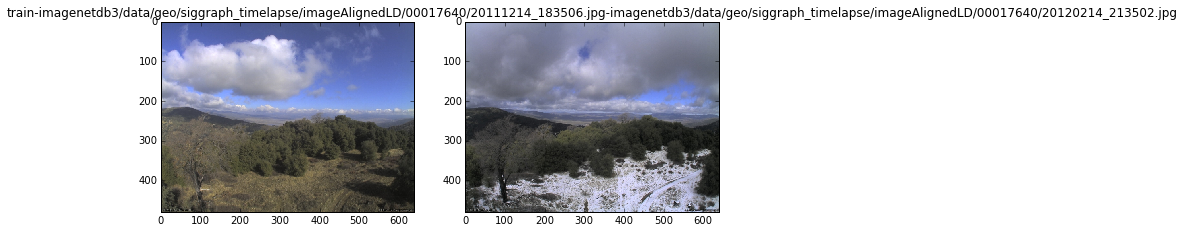

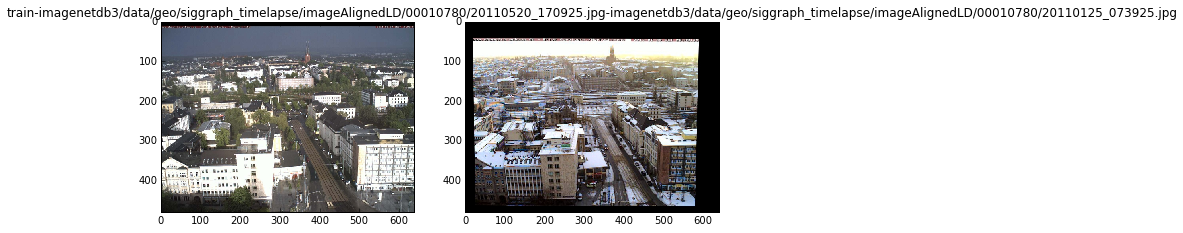

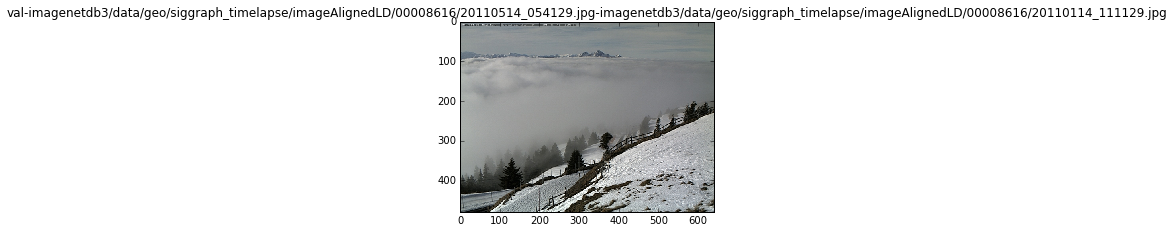

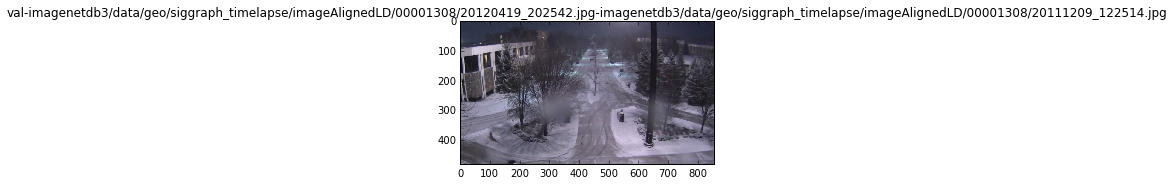

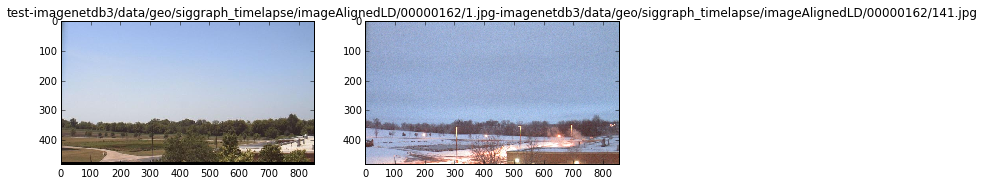

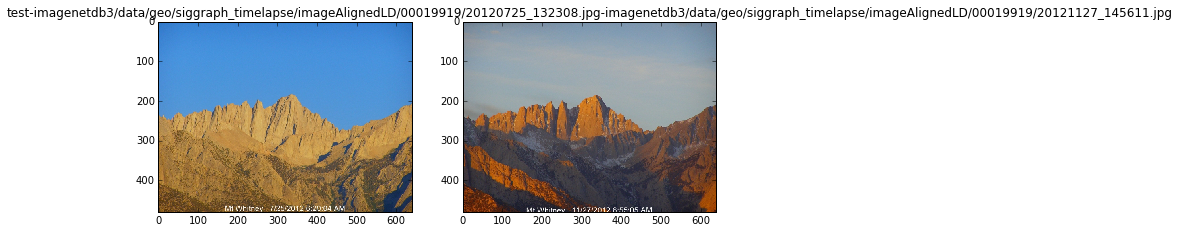

In [138]:
print train_pairs[0][0]
for pairs in train_pairs:    
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(plt.imread(os.path.join('/',pairs[0])))
    plt.subplot(1,2,2)
    plt.imshow(plt.imread(os.path.join('/',pairs[2])))
    plt.title('train-%s-%s'%(pairs[0],pairs[2]))

    
for pairs in val_pairs:   
    plt.figure()
    plt.imshow(plt.imread(os.path.join('/',pairs[0])))
    plt.subplot(1,2,2)
    plt.imshow(plt.imread(os.path.join('/',pairs[2])))
    plt.title('val-%s-%s'%(pairs[0],pairs[2]))

for pairs in test_pairs:
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(plt.imread(os.path.join('/',pairs[0])))
    plt.subplot(1,2,2)
    plt.imshow(plt.imread(os.path.join('/',pairs[2])))
    plt.title('test-%s-%s'%(pairs[0],pairs[2]))


In [144]:
#Take out some bad pairs (after visually inspecting elements)
from operator import itemgetter
bad_train_list=[3,5,10,15]
bad_pairs=itemgetter(*bad_train_list) (train_pairs)
for b in bad_pairs:
    train_pairs.remove(b)



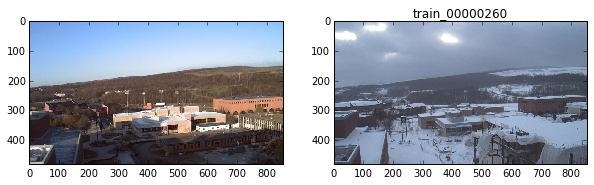

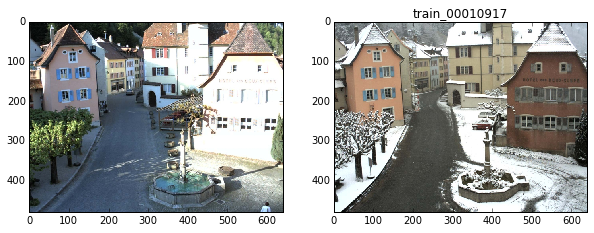

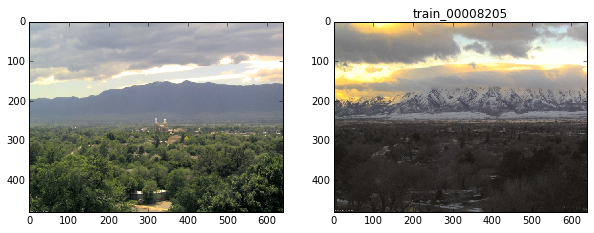

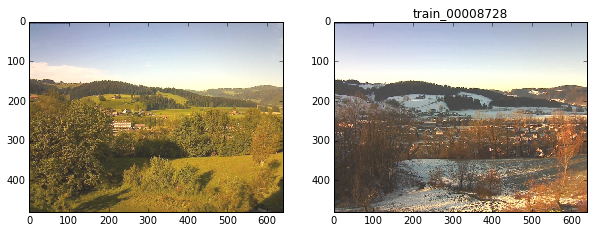

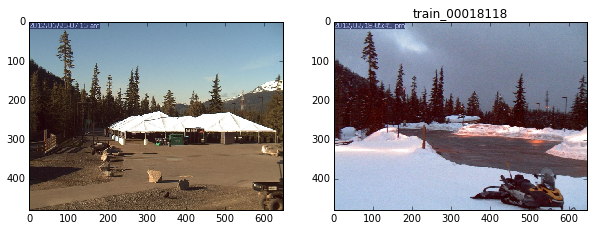

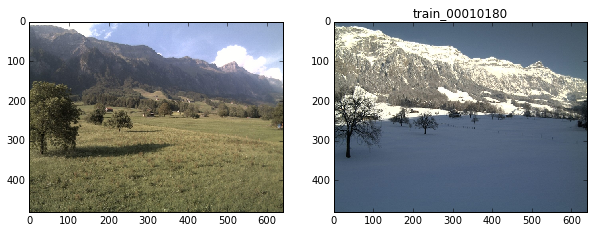

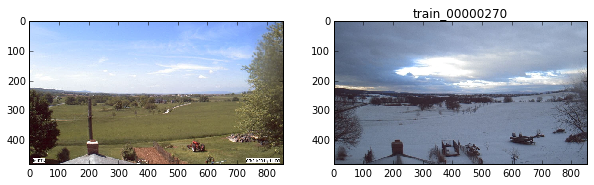

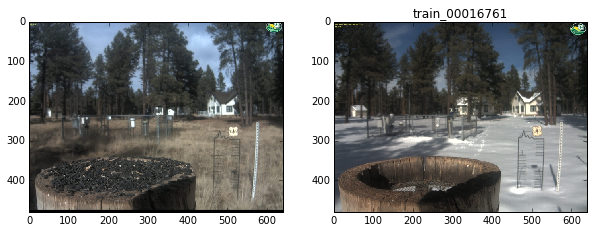

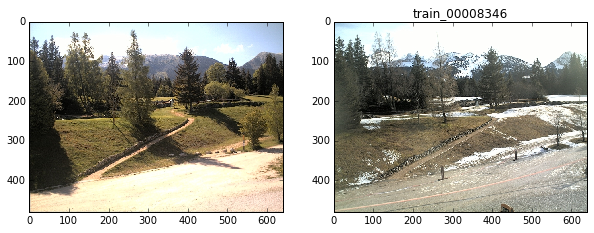

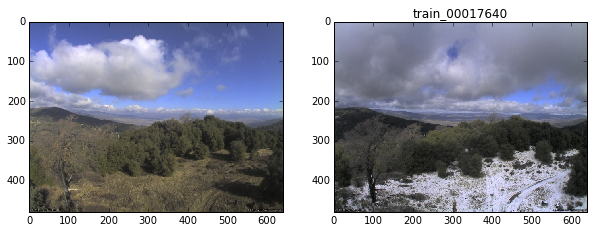

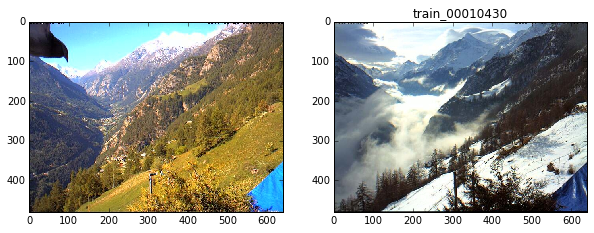

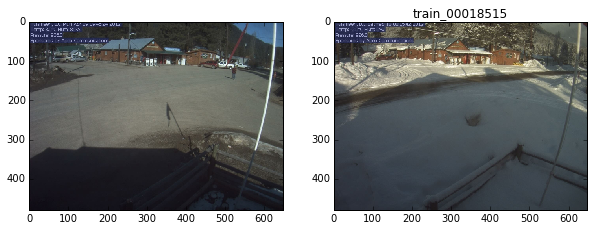

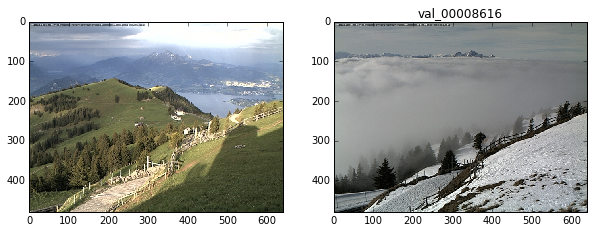

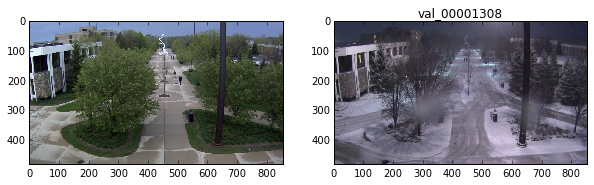

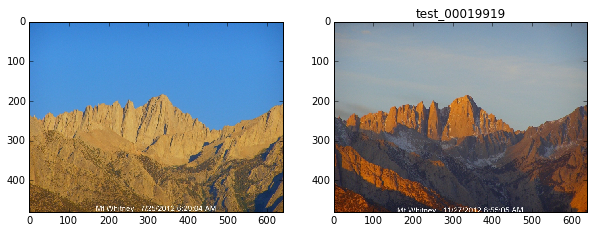

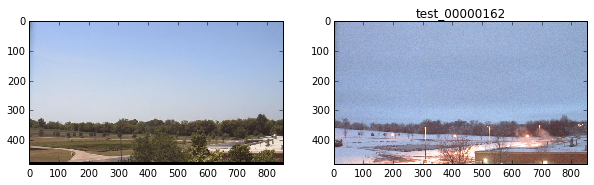

In [149]:
shuffle(train_pairs)
shuffle(val_pairs)
shuffle(test_pairs)
for pairs in train_pairs:
    fig,ax=plt.subplots()
    plt.subplot(1,2,1)
    plt.imshow(plt.imread(os.path.join('/',pairs[0])))
    plt.subplot(1,2,2)
    plt.imshow(plt.imread(os.path.join('/',pairs[2])))
    plt.title('train_%s'%pairs[0].split('/')[5])
    
for pairs in val_pairs:
    fig,ax=plt.subplots()
    plt.subplot(1,2,1)
    plt.imshow(plt.imread(os.path.join('/',pairs[0])))
    plt.subplot(1,2,2)
    plt.imshow(plt.imread(os.path.join('/',pairs[2])))
    plt.title('val_%s'%pairs[0].split('/')[5])
    
for pairs in test_pairs:
    fig,ax=plt.subplots()
    plt.subplot(1,2,1)
    plt.imshow(plt.imread(os.path.join('/',pairs[0])))
    plt.subplot(1,2,2)
    plt.imshow(plt.imread(os.path.join('/',pairs[2])))
    plt.title('test_%s'%pairs[0].split('/')[5])


In [151]:
output_data_root='/scr/r6/tgebru/inverting_conv/caffe_invert_alexnet/data/siggraph'

train_source_file=os.path.join(output_data_root,
                               'tiny_summer_train.txt')
train_target_file=os.path.join(output_data_root,
                               'tiny_winter_train.txt')

val_source_file=os.path.join(output_data_root,
                             'tiny_summer_val.txt')
val_target_file=os.path.join(output_data_root,
                             'tiny_winter_val.txt')

test_source_file=os.path.join(output_data_root,
                             'tiny_summer_test.txt')
test_target_file=os.path.join(output_data_root,
                             'tiny_winter_test.txt')

fs=open(train_source_file,'w')
ft=open(train_target_file,'w')

fvs=open(val_source_file,'w')
fvt=open(val_target_file,'w')

fts=open(test_source_file,'w')
ftt=open(test_target_file,'w')

for p in train_pairs:
    #0 at the end because cafafe model expects labels
    fs.write('%s 0\n'%p[0])  
    ft.write('%s 0\n'%p[2])
    
for p in val_pairs:
    fvs.write('%s 0\n'%p[0])
    fvt.write('%s 0\n'%p[2])
    
for p in test_pairs:
    fts.write('%s 0\n'%p[0])
    ftt.write('%s 0\n'%p[2])
    
fs.close()
ft.close()
fvs.close()
fvt.close()
ftt.close()
    

In [152]:
print num_pairs

20
